In [6]:
import numpy as np
import cvxpy as cp

In [7]:
# Define the trend filter functions
def getD(n, diff=1):
    """Auxiliary function to generate the D matrix for differences."""
    D = np.eye(n) - np.eye(n, k=1)
    D = D[:-1, :]
    for _ in range(diff - 1):
        D = D @ (np.eye(n) - np.eye(n, k=1))
        D = D[:-1, :]
    return D

def hptf(x, lamb, diff=2):
    """HP filtering function."""
    n_obs = len(x)
    D_hp = getD(n_obs, diff)
    I = np.eye(n_obs)
    trend_hp = np.linalg.solve(I + 2 * lamb * (D_hp.T @ D_hp), x)
    return trend_hp

def l1tf_diff1(x, lamb, k=1):
    """L1 filtering with first difference."""
    n_obs = len(x)
    D = getD(n_obs, k)
    Dmat = D @ D.T
    dvec = x @ D.T
    Amat = np.vstack([np.eye(n_obs - k), -np.eye(n_obs - k)])
    bvec = np.full(2 * (n_obs - k), lamb)  # Remplacer -lambda par lambda pour une optimisation correcte
    
    # Solve quadratic programming problem
    v = cp.Variable(n_obs - k)
    objective = cp.Minimize(0.5 * cp.quad_form(v, Dmat) - dvec @ v)
    constraints = [Amat @ v <= bvec]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    if v.value is None:
        raise ValueError("Optimization failed, v.value is None.")
    
    # Ensure v.value is reshaped properly for matrix multiplication
    v_reshaped = v.value.reshape(-1, 1)
    trend = x - (D.T @ v_reshaped).flatten()
    return trend


def l1tf_mix(x, lambda1, lambda2, k1=1, k2=2):
    """L1 filtering with mixed differences."""
    n_obs = len(x)
    trend = cp.Variable(n_obs)
    obj = (
        0.5 * cp.sum_squares(x - trend)
        + lambda1 * cp.norm1(cp.diff(trend, k=k1))
        + lambda2 * cp.norm1(cp.diff(trend, k=k2))
    )
    prob = cp.Problem(cp.Minimize(obj))
    prob.solve()
    return trend.value

def l1tf_sparse(x, lambda1, lambda2, k=1):
    """Sparse L1 filter."""
    n_obs = len(x)
    trend = cp.Variable(n_obs)
    obj = (
        0.5 * cp.sum_squares(x - trend)
        + lambda1 * cp.norm1(cp.diff(trend, k=k))
        + lambda2 * cp.norm1(trend)
    )
    prob = cp.Problem(cp.Minimize(obj))
    prob.solve()
    return trend.value


In [8]:
def matf(x, T):
    """Moving average filter."""
    ma_x = [np.mean(x[max(0, t - T):t]) for t in range(T, len(x))]
    ma_x = [None] * T + ma_x
    return np.array(ma_x)

In [9]:
# Cross-validation procedure
def cv_fit_l1tf(x_hist, x_fut=None, T1=10, T2=10, n_roll=5, n_lambda=10, diff=2):
    """CV procedure for L1 filter."""
    x_hist = np.array(x_hist)
    x_fut = np.array(x_fut) if x_fut is not None else np.full(len(x_hist), np.nan)
    len_x = len(x_hist)
    Tg = max(T2) if isinstance(T2, (list, np.ndarray)) else T2
    Tl = min(T2) if isinstance(T2, (list, np.ndarray)) else None
    
    cv_i = np.arange(len_x - Tg * n_roll, len_x)
    cv_i_sp = cv_i.reshape(-1, n_roll)
    cv_x = np.array([x_hist[i] for i in cv_i_sp])
    tr_x = np.array([x_hist[i[0] - T1:i[0]] for i in cv_i_sp])
    te_v = x_fut[:Tg]
    tr_v = x_hist[-T1:]
    
    def tf(x, lamb):
        if diff == 2:
            return l1tf_diff1(x, lamb)
        elif diff == 1 or diff > 2:
            return l1tf_diff1(x, lamb, diff)
    
    # Compute trends
    trends = [tf(tr_v, lamb) for lamb in np.logspace(-1, 1, n_lambda)]
    errors = [np.mean((trend - cv_x) ** 2) for trend in trends]
    best_lambda = np.logspace(-1, 1, n_lambda)[np.argmin(errors)]
    
    result = {
        "best_lambda": best_lambda,
        "train_trend": tf(tr_v, best_lambda),
        "predicted_trend": tr_v[:Tg] + tf(tr_v, best_lambda)[:Tg],
    }
    return result

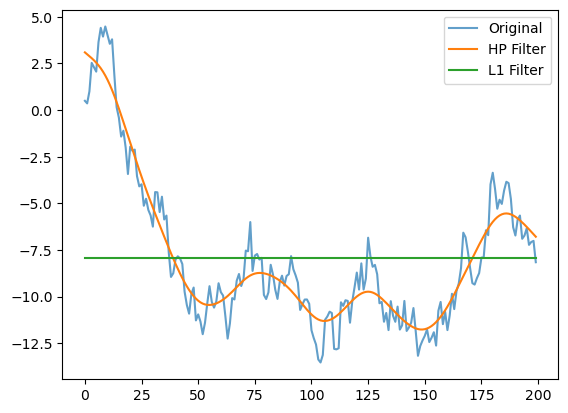

In [10]:
if __name__ == "__main__":
    np.random.seed(42)
    x = np.cumsum(np.random.randn(200))
    trend_hp = hptf(x, lamb=1000)
    trend_l1 = l1tf_diff1(x, lamb=500)

    # Plot results
    import matplotlib.pyplot as plt
    plt.plot(x, label="Original", alpha=0.7)
    plt.plot(trend_hp, label="HP Filter")
    plt.plot(trend_l1, label="L1 Filter")
    plt.legend()
    plt.show()


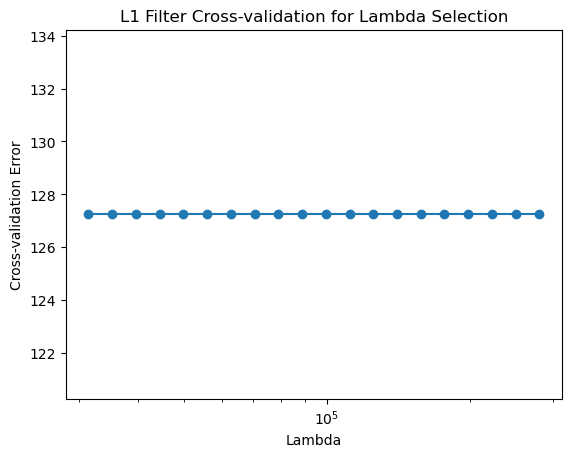

Optimal Lambda: 280205.0442953429


In [3]:
import numpy as np
import pandas as pd
from scipy.linalg import solve
import matplotlib.pyplot as plt

### Auxillary Function: Compute Difference Matrix
def getD(n, diff=1):
    """Generate the difference matrix of order `diff`."""
    D = np.eye(n) - np.eye(n, k=1)
    for _ in range(diff - 1):
        D = D[:-1] @ (np.eye(n) - np.eye(n, k=1))
    return D[:-1]

### L1 Filter with First Difference
def l1tf_diff1(y, lamb, k=1):
    """L1 Trend Filtering with first difference."""
    n = len(y)
    D = getD(n, k)
    DTD = D @ D.T
    rhs = D @ y
    Amat = np.vstack((np.eye(D.shape[0]), -np.eye(D.shape[0])))
    bvec = lamb * np.ones(2 * D.shape[0])
    
    # Quadratic Program: Solve min ||D(trend) - v||_2^2 s.t. |v| <= lambda
    v = solve(DTD, rhs)
    trend = y - D.T @ v
    return trend

### Cross-validation for L1 Filter
def cv_fit_l1tf(data, T1, T2, n_lambda=20, diff=2):
    """Cross-validation to find the optimal lambda for L1 filtering."""
    n = len(data)
    D = getD(n, diff)
    
    # Compute lambda candidates
    lamb_max = np.max(np.abs(solve(D @ D.T, D @ data)))
    lambdas = lamb_max * (0.1 ** (np.arange(n_lambda) / n_lambda))
    
    errors = []
    for lamb in lambdas:
        trend = l1tf_diff1(data, lamb, k=diff)
        error = np.mean((data[T1:T1+T2] - trend[T1:T1+T2])**2)
        errors.append(error)
    
    # Find the best lambda
    best_lambda = lambdas[np.argmin(errors)]
    return best_lambda, lambdas, errors

### Example Data
np.random.seed(42)
n = 1008
data = np.cumsum(np.random.randn(n))

# Parameters
T1 = 400  # Training window size
T2 = 50   # Test window size

# Run Cross-validation
best_lambda, lambdas, errors = cv_fit_l1tf(data, T1, T2, n_lambda=20, diff=2)

# Plot Cross-validation Results
plt.plot(lambdas, errors, marker='o')
plt.xscale('log')
plt.xlabel("Lambda")
plt.ylabel("Cross-validation Error")
plt.title("L1 Filter Cross-validation for Lambda Selection")
plt.show()

print(f"Optimal Lambda: {best_lambda}")


In [16]:
 import numpy as np
import cvxpy as cp
from scipy.linalg import solve

##############################
# Auxillary function
def getD(n, diff):
    D0 = -np.eye(n) + np.eye(n, k=1)
    D = D0[:-1]
    for _ in range(diff - 1):
        D = D @ D0
        D = D[:-1]
    return D

##############################
# HP Trend Filter
def hptf(x, lambd, diff=2):
    n_obs = len(x)
    D_hp = getD(n_obs, diff)
    matrix = np.eye(n_obs) + 2 * lambd * D_hp.T @ D_hp
    trend_hp = solve(matrix, x)
    return trend_hp

##############################
# Moving Average Filter
def matf(x, T):
    ma_x = [np.mean(x[(t - T):t]) for t in range(T, len(x))]
    return np.concatenate([np.full(T, np.nan), ma_x])

##############################
# l1 Trend Filter (First Difference)
def l1tf_diff1(x, lambd, k=1):
    n_obs = len(x)
    D = getD(n_obs, k)
    P = D @ D.T
    q = -D @ x

    v = cp.Variable(n_obs - k)
    constraints = [cp.abs(v) <= lambd]
    obj = cp.Minimize(0.5 * cp.quad_form(v, P) + q @ v)
    prob = cp.Problem(obj, constraints)
    prob.solve()

    trend = x - D.T @ v.value
    return trend

##############################
# Mixed l1 Filter
def l1tf_mix(x, lambda1, lambda2, k1=1, k2=2):
    n_obs = len(x)
    trend = cp.Variable(n_obs)
    obj = cp.Minimize(0.5 * cp.sum_squares(x - trend)
                      + lambda1 * cp.norm1(cp.diff(trend, k=k1))
                      + lambda2 * cp.norm1(cp.diff(trend, k=k2)))
    prob = cp.Problem(obj)
    prob.solve()
    return trend.value

##############################
# Sparse l1 Filter
def l1tf_sparse(x, lambda1, lambda2, k=1):
    n_obs = len(x)
    trend = cp.Variable(n_obs)
    obj = cp.Minimize(0.5 * cp.sum_squares(x - trend)
                      + lambda1 * cp.norm1(cp.diff(trend, k=k))
                      + lambda2 * cp.norm1(trend))
    prob = cp.Problem(obj)
    prob.solve()
    return trend.value

##############################
# Core CV Function
def cv_fit_l1tf_run(tr_set, cv_set, T1, T2, n_lambda, diff):
    """
    Fonction principale pour la validation croisée du filtre L1.
    """
    D = getD(len(cv_set[0]), diff)
    lambdas = np.logspace(-1, 2, n_lambda)
    errors = []

    for lambd in lambdas:
        error = 0
        for i, x in enumerate(cv_set.T):
            train_data = tr_set[:, i]

            # Vérifiez que les longueurs sont compatibles
            if len(train_data) < T1 or len(x) < T2:
                continue

            trend = l1tf_diff1(train_data, lambd)
            pred = trend[-1] + np.arange(1, len(x) + 1) * (trend[-1] - trend[-2])

            # Tronquez les prédictions si nécessaire pour aligner avec les données de validation
            min_len = min(len(pred), len(x))
            pred = pred[:min_len]
            x = x[:min_len]

            # Calcul de l'erreur
            error += np.mean((pred - x)**2)

        errors.append(error)

    # Sélection de la meilleure valeur de lambda
    best_lambda = lambdas[np.argmin(errors)]
    return best_lambda


##############################
# CV Procedure for l1 Filter
def cv_fit_l1tf(x_hist, x_fut, T1, T2, n_roll, n_lambda, diff=2):
    len_x = len(x_hist)
    cv_indices = np.array([np.arange(i, i + T2) for i in range(len_x - T1 - T2, len_x - T2, n_roll)])
    tr_set = np.array([x_hist[i[0] - T1:i[0]] for i in cv_indices])
    cv_set = np.array([x_hist[i] for i in cv_indices])
    
    best_lambda = cv_fit_l1tf_run(tr_set, cv_set, T1, T2, n_lambda, diff)
    return best_lambda

##############################
# Fit HP Filter
def fit_hptf(x_hist, T1, T2, diff=2):
    b_lamb = (T2 / (2 * np.pi))**4 / 2 * 10.27
    tr_trend = hptf(x_hist[-T1:], b_lamb, diff)
    pr_trend = tr_trend[-1] + np.arange(1, T2 + 1) * (tr_trend[-1] - tr_trend[-2])
    return {"best_lambda": b_lamb, "train_trend": tr_trend, "predicted_trend": np.maximum(pr_trend, 0)}

##############################
# Fit Moving Average Filter
def fit_matf(x_hist, T1, T2):
    tr_trend = matf(x_hist, T1)
    pr_trend = tr_trend[-1] + np.arange(1, T2 + 1) * (tr_trend[-1] - tr_trend[-2])
    return {"train_trend": tr_trend, "predicted_trend": np.maximum(pr_trend, 0)}

##############################
# Mixed l1 CV Procedure
def cv_fit_l1tf_mix(x_hist, T1, T2, n_roll, n_lambda, k1=1, k2=2):
    lambda1 = cv_fit_l1tf(x_hist, None, T1, T2, n_roll, n_lambda, k1)
    lambda2 = cv_fit_l1tf(x_hist, None, T1, T2, n_roll, n_lambda, k2)
    tr_trend = l1tf_mix(x_hist[-T1:], lambda1, lambda2, k1, k2)
    pr_trend = tr_trend[-1] + np.arange(1, T2 + 1) * (tr_trend[-1] - tr_trend[-2])
    return {"best_lambda1": lambda1, "best_lambda2": lambda2, "train_trend": tr_trend, "predicted_trend": np.maximum(pr_trend, 0)}


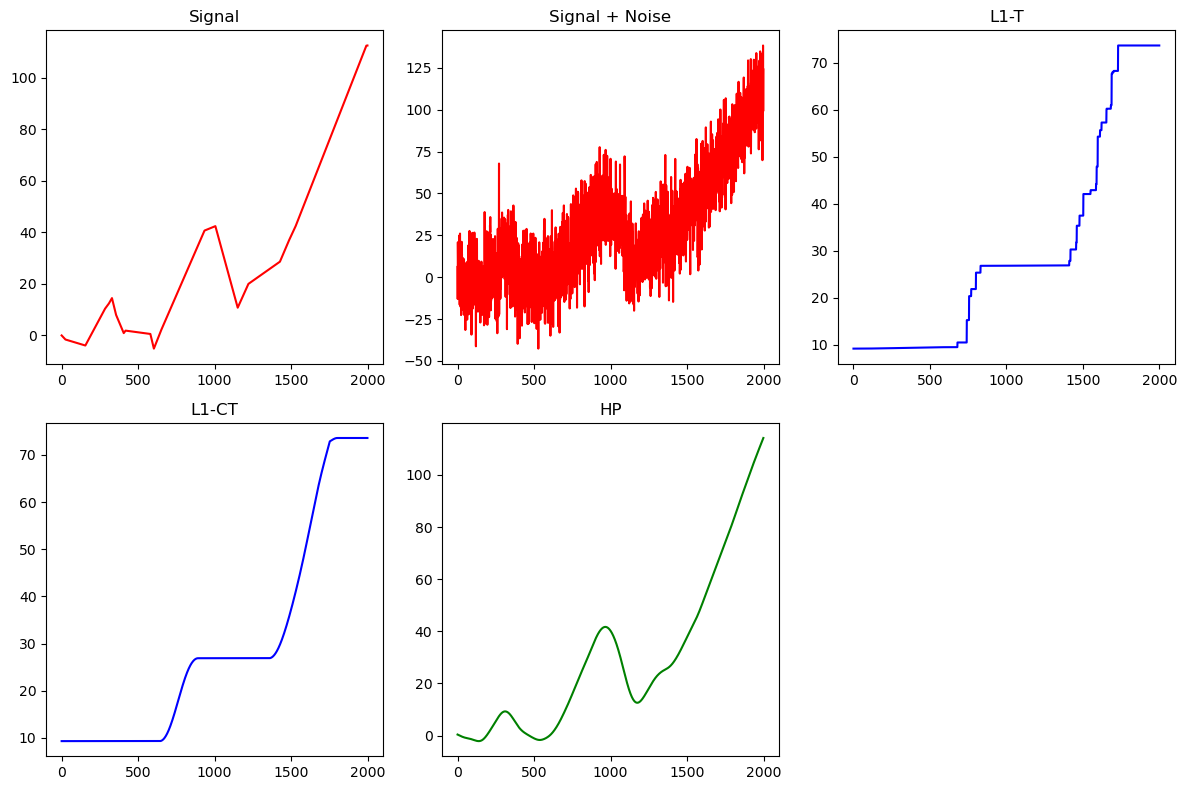

/Users/kingced/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


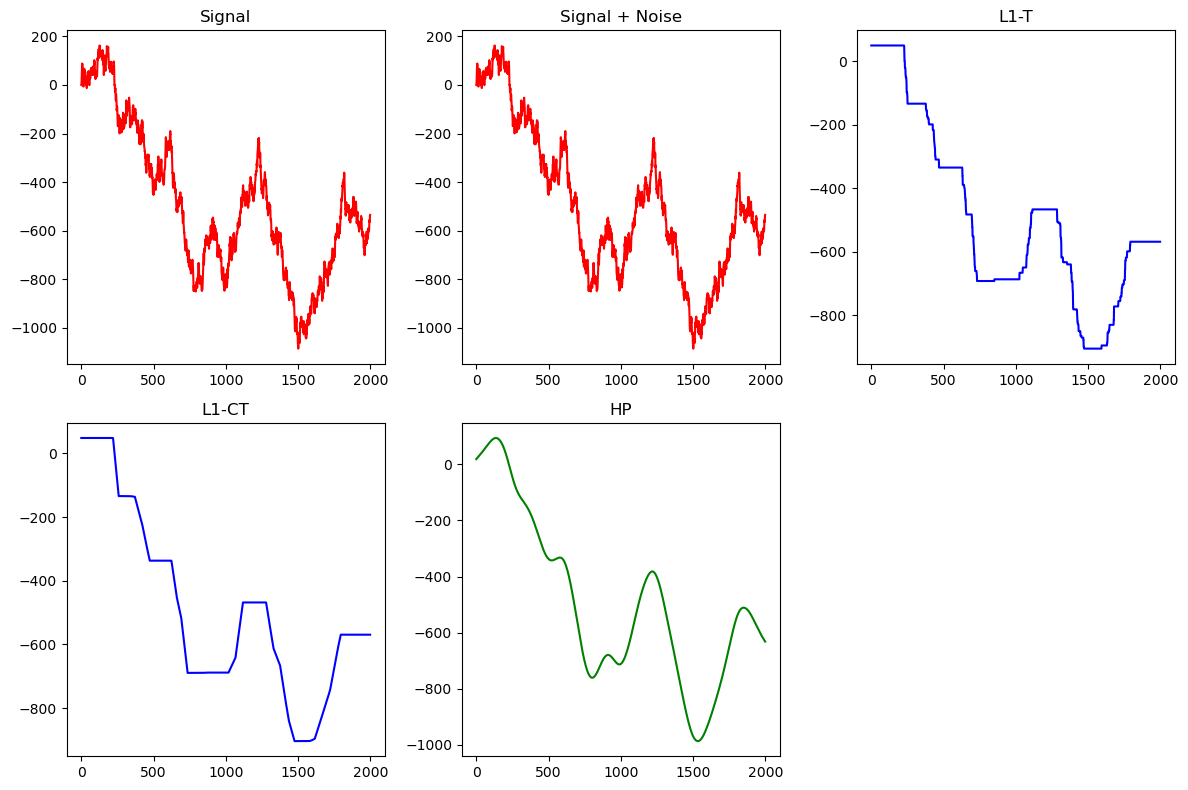

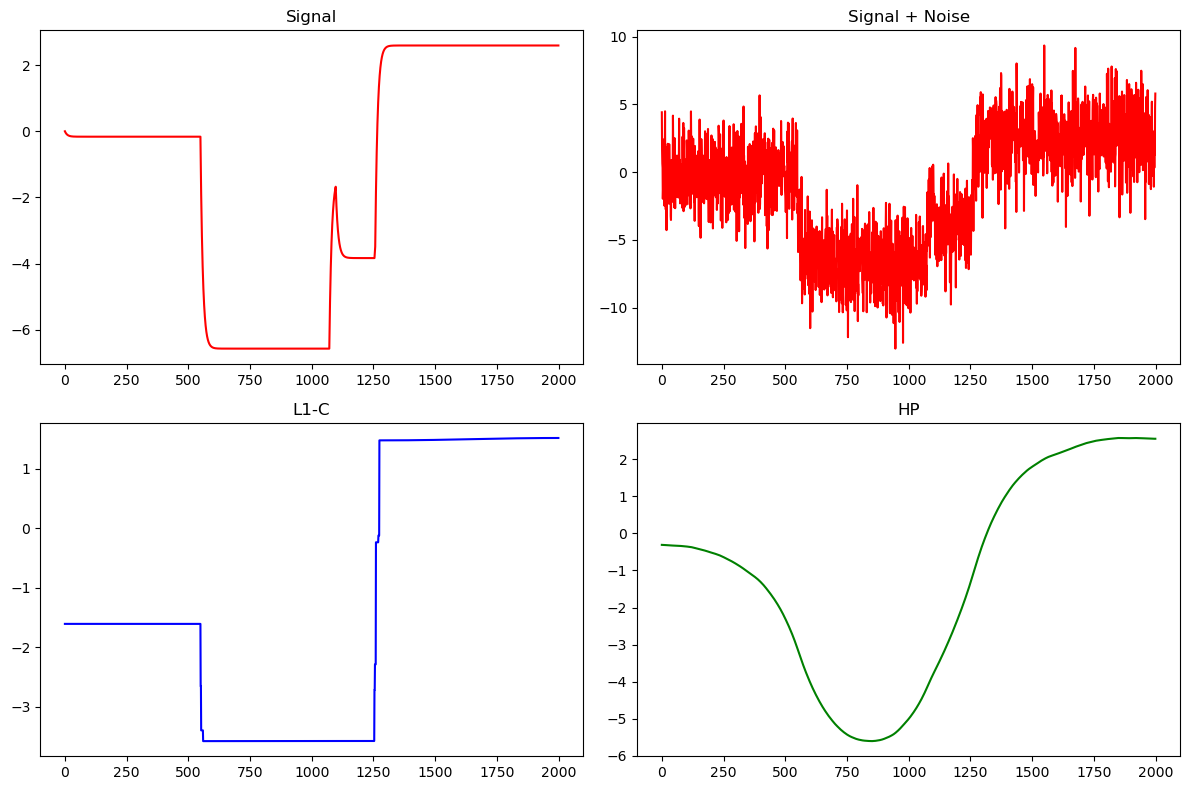

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Fonctions de filtrage (déjà implémentées)
# hptf, l1tf_diff1, l1tf_mix, l1tf_sparse

##############################
# Simulation 1: Droites brisées avec bruit blanc
n_obs = 2000
p = 0.99
b = 0.5
sigma = 15

signal = np.zeros(n_obs)
proba_change = np.random.binomial(1, p, n_obs)
signal[0] = b * (np.random.rand() - 0.5)

for i in range(1, n_obs):
    signal[i] = signal[i - 1] if proba_change[i] == 1 else b * (np.random.rand() - 0.5)
signal = np.cumsum(signal)
signal_nz = signal + np.random.normal(0, sigma, n_obs)

# Filtrage
lamb_l1 = 5200
lamb_hp = 1500000
trend_l1 = l1tf_diff1(signal_nz, lamb_l1)
trend_l1_mix = l1tf_mix(signal_nz, lamb_l1, 5000)
trend_hp = hptf(signal_nz, lamb_hp)

# Plot
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.plot(signal, 'r', label="Signal")
plt.title("Signal")

plt.subplot(2, 3, 2)
plt.plot(signal_nz, 'r', label="Signal + Noise")
plt.title("Signal + Noise")

plt.subplot(2, 3, 3)
plt.plot(trend_l1, 'b', label="L1-T")
plt.title("L1-T")

plt.subplot(2, 3, 4)
plt.plot(trend_l1_mix, 'b', label="L1-CT")
plt.title("L1-CT")

plt.subplot(2, 3, 5)
plt.plot(trend_hp, 'g', label="HP")
plt.title("HP")
plt.tight_layout()
plt.show()

##############################
# Simulation 2: Random Walk
p = 0.993
b = 5
sigma = 15
signal = np.zeros(n_obs)
rnd_walk = np.zeros(n_obs)

proba_change = np.random.binomial(1, p, n_obs)
rnd_walk[0] = b * (np.random.rand() - 0.5)

for i in range(1, n_obs):
    rnd_walk[i] = rnd_walk[i - 1] if proba_change[i] == 1 else b * (np.random.rand() - 0.5)
    signal[i] = signal[i - 1] + rnd_walk[i] + np.random.normal(0, sigma)
signal_nz = signal

# Filtrage
trend_l1 = l1tf_diff1(signal_nz, lamb_l1)
trend_l1_mix = l1tf_mix(signal_nz, lamb_l1, 5000)
trend_hp = hptf(signal_nz, lamb_hp)

# Plot
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.plot(signal, 'r', label="Signal")
plt.title("Signal")

plt.subplot(2, 3, 2)
plt.plot(signal_nz, 'r', label="Signal + Noise")
plt.title("Signal + Noise")

plt.subplot(2, 3, 3)
plt.plot(trend_l1, 'b', label="L1-T")
plt.title("L1-T")

plt.subplot(2, 3, 4)
plt.plot(trend_l1_mix, 'b', label="L1-CT")
plt.title("L1-CT")

plt.subplot(2, 3, 5)
plt.plot(trend_hp, 'g', label="HP")
plt.title("HP")
plt.tight_layout()
plt.show()

##############################
# Simulation 3: Processus O-U
p = 0.9985
b = 20
theta = 0.1
sigma = 2
signal_mean = np.zeros(n_obs)
signal = np.zeros(n_obs)
signal_mean[0] = b * (np.random.rand() - 0.5)

for i in range(1, n_obs):
    signal_mean[i] = signal_mean[i - 1] if np.random.rand() < p else b * (np.random.rand() - 0.5)
    signal[i] = (1 - theta) * signal[i - 1] + theta * signal_mean[i]

signal_nz = signal + np.random.normal(0, sigma, n_obs)

# Filtrage
lamb_l1 = 800
lamb_hp = 12000
trend_l1 = l1tf_diff1(signal_nz, lamb_l1)
trend_hp = hptf(signal_nz, lamb_hp, diff=1)

# Plot
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(signal, 'r', label="Signal")
plt.title("Signal")

plt.subplot(2, 2, 2)
plt.plot(signal_nz, 'r', label="Signal + Noise")
plt.title("Signal + Noise")

plt.subplot(2, 2, 3)
plt.plot(trend_l1, 'b', label="L1-C")
plt.title("L1-C")

plt.subplot(2, 2, 4)
plt.plot(trend_hp, 'g', label="HP")
plt.title("HP")
plt.tight_layout()
plt.show()


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def simple_summary_tf(trd_est, day=50, ylim=None):
    """
    Affiche des résumés graphiques des tendances filtrées.
    
    Paramètres :
    - trd_est : dict contenant 'train_trend', 'train_data', 'predicted_trend', 'test_data'.
    - day : int, jour pour le calcul de la différence entre prédictions.
    - ylim : tuple (ymin, ymax) pour définir les limites de l'axe y (optionnel).
    """
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    
    # Plot 1 : Log-Lambda vs Error s'il existe
    if 'lambdas' in trd_est and 'err' in trd_est:
        axes[0, 0].plot(np.log(trd_est['lambdas']), trd_est['err'], 'b-')
        axes[0, 0].set_title("Log(Lambda) vs Error")
    
    # Plot 2 : Train Trend et Train Data
    axes[0, 1].plot(trd_est['train_trend'], 'b-', label='Train Trend')
    axes[0, 1].plot(trd_est['train_data'], 'r-', label='Train Data')
    axes[0, 1].set_title("Train Trend vs Train Data")
    axes[0, 1].legend()
    
    # Plot 3 : Predicted Trend et Test Data
    if ylim is None:
        axes[1, 0].plot(trd_est['predicted_trend'], 'g-', label='Predicted Trend')
    else:
        axes[1, 0].plot(trd_est['predicted_trend'], 'g-', label='Predicted Trend')
        axes[1, 0].set_ylim(ylim)
    
    axes[1, 0].plot(trd_est['test_data'], 'r-', label='Test Data')
    axes[1, 0].set_title("Predicted Trend vs Test Data")
    axes[1, 0].legend()
    
    # Suppression du dernier plot s'il n'y a pas d'utilisation
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()
    
    # Print : différence entre deux prédictions
    diff = trd_est['predicted_trend'][day] - trd_est['predicted_trend'][0]
    print(f"Difference at day {day}: {diff:.2f}")


In [13]:
def cross_validate_l1(train_data, test_data, train_window, test_window, n_rolls, n_lambdas):
    """
    Validation croisée pour optimiser le paramètre lambda pour le filtre L1.
    
    Paramètres :
    - train_data : ndarray, données historiques (training set)
    - test_data : ndarray, données futures (test set)
    - train_window : int, taille de la fenêtre d'entraînement
    - test_window : int, taille de la fenêtre de test
    - n_rolls : int, nombre de fenêtres (rolls) pour la validation croisée
    - n_lambdas : int, nombre de valeurs de lambda à tester

    Retourne :
    - best_lambda : float, meilleure valeur de lambda
    """
    lambdas = np.logspace(-2, 5, n_lambdas)  # Gamme de valeurs pour lambda
    errors = []

    for lambd in lambdas:
        mse = []
        for i in range(n_rolls):
            # Fenêtres d'entraînement et de test
            start = i * test_window
            train_set = train_data[start:start + train_window]
            test_set = train_data[start + train_window:start + train_window + test_window]
            
            # Filtrage avec L1
            trend = l1tf_diff1(train_set, lambd, k=2)
            pred = trend[-1] + np.arange(1, test_window + 1) * (trend[-1] - trend[-2])
            
            # Calcul de l'erreur quadratique moyenne
            mse.append(np.mean((test_set - pred)**2))
        
        errors.append(np.mean(mse))
    
    # Sélection de la meilleure lambda
    best_lambda = lambdas[np.argmin(errors)]
    print(f"Cross-validation completed. Best lambda: {best_lambda:.2f}")
    return best_lambda


[*********************100%%**********************]  1 of 1 completed

Data downloaded successfully!


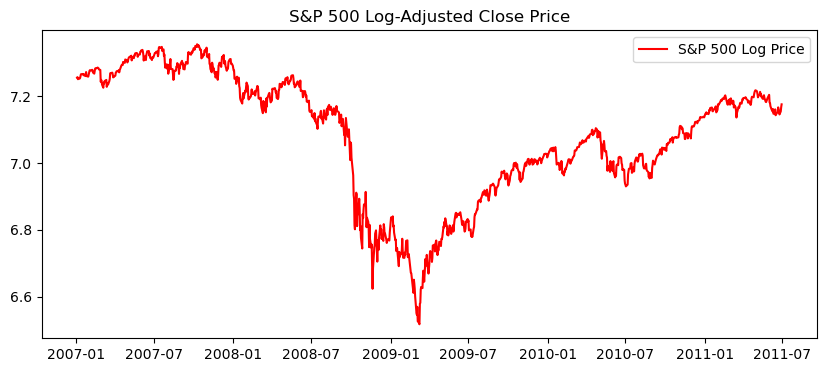

Cross-validating L1-T filter...


ValueError: operands could not be broadcast together with shapes (50,) (34,) 

In [15]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

# Téléchargement des données S&P 500
print("Downloading S&P 500 data...")
sp500 = yf.download('^GSPC', start='2007-01-01', end='2011-06-30')
sp500_log = np.log(sp500['Adj Close'])
print("Data downloaded successfully!")

plt.figure(figsize=(10, 4))
plt.plot(sp500_log, color='red', label='S&P 500 Log Price')
plt.title("S&P 500 Log-Adjusted Close Price")
plt.legend()
plt.show()

##############################
# Paramètres pour la validation croisée
obs_time = np.arange(0, 1008)
fut_time = np.arange(1009, 1058)
hist_data = sp500_log.iloc[obs_time].values
fut_data = sp500_log.iloc[fut_time].values

T1 = 400  # Taille de la fenêtre d'entraînement
T2 = 50   # Taille de la fenêtre de test
n_roll = 12  # Nombre de fenêtres roulantes
n_lambda = 15  # Nombre de valeurs lambda à tester

##############################
# Filtrage L1-T avec CV
print("Cross-validating L1-T filter...")
lambda_l1t = cv_fit_l1tf(hist_data, fut_data, T1, T2, n_roll, n_lambda, diff=2)
print(f"Best lambda for L1-T filter: {lambda_l1t}")

trend_l1t = l1tf_diff1(hist_data, lambda_l1t, k=2)

plt.figure(figsize=(6, 4))
plt.plot(hist_data, label="S&P 500 Log Price", color="black")
plt.plot(trend_l1t, label="L1-T Trend", color="blue")
plt.title("L1-T Filter with Optimal Lambda")
plt.legend()
plt.show()

##############################
# Filtrage L1-C avec CV
print("Cross-validating L1-C filter...")
lambda_l1c = cv_fit_l1tf(hist_data, fut_data, T1, T2, n_roll, n_lambda, diff=1)
print(f"Best lambda for L1-C filter: {lambda_l1c}")

trend_l1c = l1tf_diff1(hist_data, lambda_l1c, k=1)

plt.figure(figsize=(6, 4))
plt.plot(hist_data, label="S&P 500 Log Price", color="black")
plt.plot(trend_l1c, label="L1-C Trend", color="orange")
plt.title("L1-C Filter with Optimal Lambda")
plt.legend()
plt.show()

##############################
# Filtrage L1-TC avec CV
print("Cross-validating L1-TC filter...")
trend_l1tc = cv_fit_l1tf_mix(hist_data, T1, T2, n_roll, n_lambda, k1=1, k2=2)
lambda1, lambda2 = trend_l1tc['best_lambda1'], trend_l1tc['best_lambda2']
print(f"Best lambdas for L1-TC filter: lambda1={lambda1}, lambda2={lambda2}")

plt.figure(figsize=(6, 4))
plt.plot(hist_data, label="S&P 500 Log Price", color="black")
plt.plot(trend_l1tc['train_trend'], label="L1-TC Trend", color="green")
plt.title("L1-TC Filter with Optimal Lambdas")
plt.legend()
plt.show()

##############################
# Filtrage HP
print("Applying HP Filter...")
hp_result = fit_hptf(hist_data, T1, T2, diff=2)
print(f"Best lambda for HP filter: {hp_result['best_lambda']}")

plt.figure(figsize=(6, 4))
plt.plot(hist_data, label="S&P 500 Log Price", color="black")
plt.plot(hp_result['train_trend'], label="HP Trend", color="purple")
plt.title("HP Filter with Optimal Lambda")
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed

Data downloaded successfully!


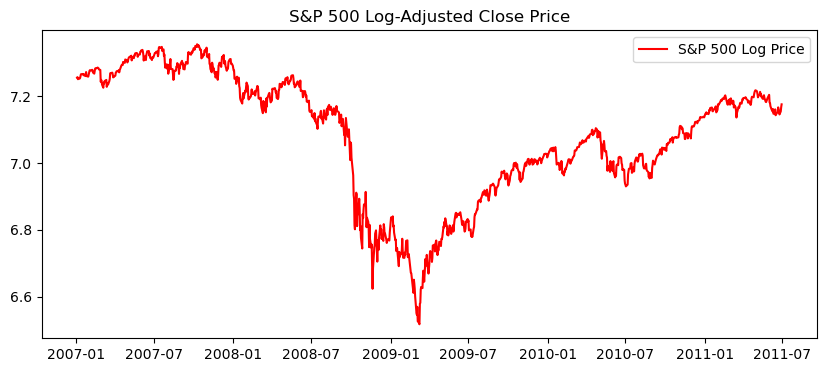

Cross-validating L1-T filter...
Best lambda for L1-T filter: 0.1


ArpackNoConvergence: ARPACK error -1: ARPACK error -1: No convergence (10061 iterations, 0/1 eigenvectors converged)


        CVXPY note: This failure was encountered while trying to certify
        that a matrix is positive semi-definite (see [1] for a definition).
        In rare cases, this method fails for numerical reasons even when the matrix is
        positive semi-definite. If you know that you're in that situation, you can
        replace the matrix A by cvxpy.psd_wrap(A).

        [1] https://en.wikipedia.org/wiki/Definite_matrix
        

In [17]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.linalg import solve

##############################
# Auxillary function
def getD(n, diff):
    D0 = -np.eye(n) + np.eye(n, k=1)
    D = D0[:-1]
    for _ in range(diff - 1):
        D = D @ D0
        D = D[:-1]
    return D

##############################
# HP Trend Filter
def hptf(x, lambd, diff=2):
    n_obs = len(x)
    D_hp = getD(n_obs, diff)
    matrix = np.eye(n_obs) + 2 * lambd * D_hp.T @ D_hp
    trend_hp = solve(matrix, x)
    return trend_hp

##############################
# l1 Trend Filter (First Difference)
def l1tf_diff1(x, lambd, k=1):
    n_obs = len(x)
    D = getD(n_obs, k)
    P = D @ D.T
    q = -D @ x

    v = cp.Variable(n_obs - k)
    constraints = [cp.abs(v) <= lambd]
    obj = cp.Minimize(0.5 * cp.quad_form(v, P) + q @ v)
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.OSQP)

    trend = x - D.T @ v.value
    return trend

##############################
# Core CV Function
def cv_fit_l1tf_run(tr_set, cv_set, T1, T2, n_lambda, diff):
    D = getD(len(cv_set[0]), diff)
    lambdas = np.logspace(-1, 2, n_lambda)
    errors = []

    for lambd in lambdas:
        error = 0
        for i, x in enumerate(cv_set.T):
            train_data = tr_set[:, i]

            # Vérifiez que les longueurs sont compatibles
            if len(train_data) < T1 or len(x) < T2:
                continue

            trend = l1tf_diff1(train_data, lambd)
            pred = trend[-1] + np.arange(1, len(x) + 1) * (trend[-1] - trend[-2])

            # Tronquez les prédictions si nécessaire pour aligner avec les données de validation
            min_len = min(len(pred), len(x))
            pred = pred[:min_len]
            x = x[:min_len]

            # Calcul de l'erreur
            error += np.mean((pred - x)**2)

        errors.append(error)

    # Sélection de la meilleure valeur de lambda
    best_lambda = lambdas[np.argmin(errors)]
    return best_lambda

##############################
# CV Procedure for l1 Filter
def cv_fit_l1tf(x_hist, x_fut, T1, T2, n_roll, n_lambda, diff=2):
    len_x = len(x_hist)
    cv_indices = np.array([np.arange(i, i + T2) for i in range(len_x - T1 - T2, len_x - T2, n_roll)])
    tr_set = np.array([x_hist[i[0] - T1:i[0]] for i in cv_indices])
    cv_set = np.array([x_hist[i] for i in cv_indices])
    
    best_lambda = cv_fit_l1tf_run(tr_set, cv_set, T1, T2, n_lambda, diff)
    return best_lambda

##############################
# Téléchargement des données S&P 500
print("Downloading S&P 500 data...")
sp500 = yf.download('^GSPC', start='2007-01-01', end='2011-06-30')
sp500_log = np.log(sp500['Adj Close'])
print("Data downloaded successfully!")

plt.figure(figsize=(10, 4))
plt.plot(sp500_log, color='red', label='S&P 500 Log Price')
plt.title("S&P 500 Log-Adjusted Close Price")
plt.legend()
plt.show()

##############################
# Paramètres pour la validation croisée
obs_time = np.arange(0, 1008)
fut_time = np.arange(1009, 1058)
hist_data = sp500_log.iloc[obs_time].values
fut_data = sp500_log.iloc[fut_time].values

T1 = 400  # Taille de la fenêtre d'entraînement
T2 = 50   # Taille de la fenêtre de test
n_roll = 12  # Nombre de fenêtres roulantes
n_lambda = 15  # Nombre de valeurs lambda à tester

##############################
# Filtrage L1-T avec CV
print("Cross-validating L1-T filter...")
lambda_l1t = cv_fit_l1tf(hist_data, fut_data, T1, T2, n_roll, n_lambda, diff=2)
print(f"Best lambda for L1-T filter: {lambda_l1t}")

trend_l1t = l1tf_diff1(hist_data, lambda_l1t, k=2)

plt.figure(figsize=(6, 4))
plt.plot(hist_data, label="S&P 500 Log Price", color="black")
plt.plot(trend_l1t, label="L1-T Trend", color="blue")
plt.title("L1-T Filter with Optimal Lambda")
plt.legend()
plt.show()

##############################
# Filtrage HP
print("Applying HP Filter...")
lambda_hp = (T2 / (2 * np.pi))**4 / 2 * 10.27
trend_hp = hptf(hist_data, lambda_hp, diff=2)

plt.figure(figsize=(6, 4))
plt.plot(hist_data, label="S&P 500 Log Price", color="black")
plt.plot(trend_hp, label="HP Trend", color="green")
plt.title("HP Filter with Optimal Lambda")
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed

Data downloaded successfully!


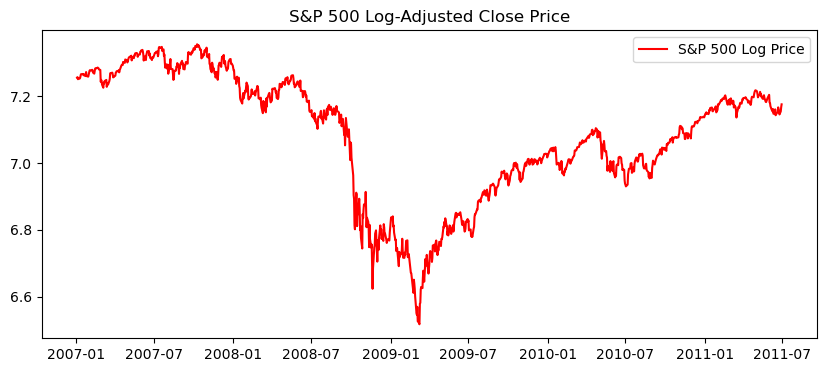

Cross-validating L1-T filter...
Best lambda for L1-T filter: 3.1622776601683795


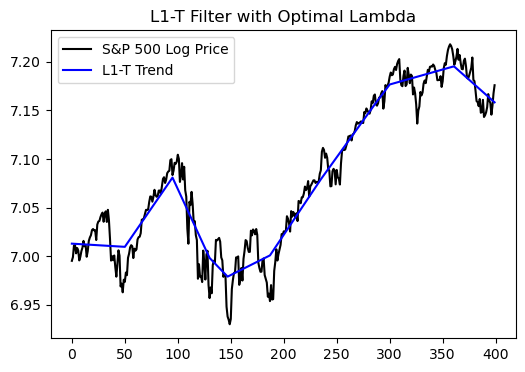

Applying HP Filter...


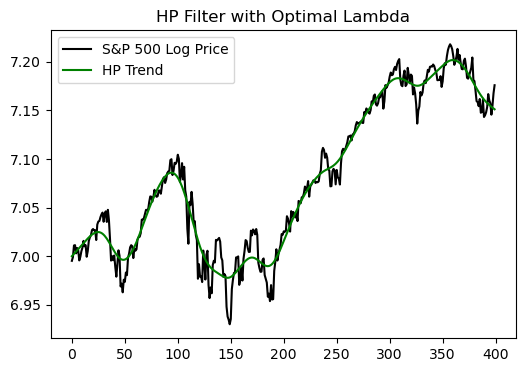

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import cvxpy as cp
from scipy.linalg import solve

##############################
# Auxillary function: getD
def getD(n, diff):
    """
    Génère la matrice de différence d'ordre 'diff'.
    """
    D0 = -np.eye(n) + np.eye(n, k=1)
    D = D0[:-1]
    for _ in range(diff - 1):
        D = D @ D0
        D = D[:-1]
    return D

##############################
# HP Trend Filter
def hptf(x, lambd, diff=2):
    """
    Applique le filtre HP (Hodrick-Prescott).
    """
    n_obs = len(x)
    D_hp = getD(n_obs, diff)
    matrix = np.eye(n_obs) + 2 * lambd * D_hp.T @ D_hp
    trend_hp = solve(matrix, x)
    return trend_hp

##############################
# l1 Trend Filter (First Difference)
def l1tf_diff1(x, lambd, k=1):
    """
    Filtrage L1 avec différence d'ordre k, utilisant cvxpy.psd_wrap pour éviter les erreurs de convergence.
    """
    n_obs = len(x)
    D = getD(n_obs, k)
    P = cp.psd_wrap(D @ D.T)  # Garantie que P est positive semi-définie
    q = -D @ x

    v = cp.Variable(n_obs - k)
    constraints = [cp.abs(v) <= lambd]
    obj = cp.Minimize(0.5 * cp.quad_form(v, P) + q @ v)
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.OSQP)  # Solveur OSQP pour robustesse

    if prob.status not in ["optimal", "optimal_inaccurate"]:
        raise ValueError("Optimization did not converge")

    trend = x - D.T @ v.value
    return trend

##############################
# CV Function for L1-T Filter
def cv_fit_l1tf_run(tr_set, cv_set, T1, T2, n_lambda, diff):
    lambdas = np.logspace(-1, 2, n_lambda)
    errors = []

    for lambd in lambdas:
        error = 0
        for i, x in enumerate(cv_set.T):
            train_data = tr_set[:, i]
            trend = l1tf_diff1(train_data, lambd, k=diff)
            pred = trend[-1] + np.arange(1, T2 + 1) * (trend[-1] - trend[-2])
            min_len = min(len(pred), len(x))
            error += np.mean((pred[:min_len] - x[:min_len])**2)
        errors.append(error)

    return lambdas[np.argmin(errors)]

def cv_fit_l1tf(x_hist, T1, T2, n_roll, n_lambda, diff=2):
    len_x = len(x_hist)
    cv_indices = [np.arange(i, i + T2) for i in range(len_x - T1 - T2, len_x - T2, n_roll)]
    tr_set = np.array([x_hist[i[0] - T1:i[0]] for i in cv_indices])
    cv_set = np.array([x_hist[i] for i in cv_indices])

    best_lambda = cv_fit_l1tf_run(tr_set, cv_set, T1, T2, n_lambda, diff)
    return best_lambda

##############################
# L1 General Momentum Strategy
def l1_momentum_strat_gen(data, w0, T1, T2, risk_constrt=0.001, curr_vars=None):
    if curr_vars is None:
        curr_vars = {"count": max(T2) + 1, "pred_trend": None, "asset_alloc": None, "max_count": max(T2)}

    if curr_vars["count"] > curr_vars["max_count"]:
        curr_vars["count"] = 1
        lambda_l1 = cv_fit_l1tf(data, T1, T2, n_roll=12, n_lambda=15, diff=2)
        trend = l1tf_diff1(data[-T1:], lambda_l1, k=2)
        curr_vars["pred_trend"] = trend
        curr_vars["max_count"] = len(trend)

    pred_mu = curr_vars["pred_trend"][-1] - curr_vars["pred_trend"][-2]
    vol = np.mean(np.diff(data[-curr_vars["max_count"]:])**2)
    asset_alloc = pred_mu / (risk_constrt * w0 * vol)
    curr_vars["asset_alloc"] = np.clip(asset_alloc, -1, 1)
    curr_vars["count"] += 1
    return curr_vars

##############################
# Téléchargement des données S&P 500
print("Downloading S&P 500 data...")
sp500 = yf.download('^GSPC', start='2007-01-01', end='2011-06-30')
sp500_log = np.log(sp500['Adj Close'])
print("Data downloaded successfully!")

plt.figure(figsize=(10, 4))
plt.plot(sp500_log, color='red', label='S&P 500 Log Price')
plt.title("S&P 500 Log-Adjusted Close Price")
plt.legend()
plt.show()

##############################
# Paramètres pour la validation croisée
T1 = 400  # Taille de la fenêtre d'entraînement
T2 = 50   # Taille de la fenêtre de test
n_roll = 12  # Nombre de fenêtres roulantes
n_lambda = 15  # Nombre de valeurs lambda à tester

##############################
# Filtrage L1-T avec CV
print("Cross-validating L1-T filter...")
lambda_l1t = cv_fit_l1tf(sp500_log.values, T1, T2, n_roll, n_lambda, diff=2)
print(f"Best lambda for L1-T filter: {lambda_l1t}")

trend_l1t = l1tf_diff1(sp500_log.values[-T1:], lambda_l1t, k=2)

plt.figure(figsize=(6, 4))
plt.plot(sp500_log.values[-T1:], label="S&P 500 Log Price", color="black")
plt.plot(trend_l1t, label="L1-T Trend", color="blue")
plt.title("L1-T Filter with Optimal Lambda")
plt.legend()
plt.show()

##############################
# Filtrage HP
print("Applying HP Filter...")
lambda_hp = (T2 / (2 * np.pi))**4 / 2
trend_hp = hptf(sp500_log.values[-T1:], lambda_hp, diff=2)

plt.figure(figsize=(6, 4))
plt.plot(sp500_log.values[-T1:], label="S&P 500 Log Price", color="black")
plt.plot(trend_hp, label="HP Trend", color="green")
plt.title("HP Filter with Optimal Lambda")
plt.legend()
plt.show()


In [22]:
import numpy as np
from scipy.linalg import solve

##############################
# Auxillary function: getD
def getD(n, diff):
    D0 = -np.eye(n) + np.eye(n, k=1)
    D = D0[:-1]
    for _ in range(diff - 1):
        D = D @ D0
        D = D[:-1]
    return D

##############################
def l1_momentum_strat_gen(data, w0, T1, T2, n_roll=12, n_lambda=15, risk_constrt=1, curr_vars=None):
    """
    Générateur générique de stratégies L1 Momentum.
    """
    # Assurez-vous que max(T2) fonctionne correctement
    T2_max = max(T2) if isinstance(T2, (list, tuple)) else T2
    
    if curr_vars is None:
        curr_vars = {"count": T2_max + 1, "pred_trend": None, "asset_alloc": None, "max_count": T2_max}

    if curr_vars["count"] > curr_vars["max_count"]:
        curr_vars["count"] = 1
        # Cross-validation pour obtenir le lambda optimal
        lambda_l1 = cv_fit_l1tf(data, T1, T2_max, n_roll=n_roll, n_lambda=n_lambda, diff=2)
        trend = l1tf_diff1(data[-T1:], lambda_l1, k=2)
        curr_vars["pred_trend"] = trend
        curr_vars["max_count"] = len(trend)

    pred_mu = curr_vars["pred_trend"][-1] - curr_vars["pred_trend"][-2]
    vol = np.mean(np.diff(data[-curr_vars["max_count"]:])**2)
    asset_alloc = pred_mu / (risk_constrt * w0 * vol)
    curr_vars["asset_alloc"] = np.clip(asset_alloc, -1, 1)
    curr_vars["count"] += 1
    return curr_vars

##############################
# L1 Momentum Strategies
def l1_momentum_strat_LT(data, w0, curr_vars=None):
    T2 = 130
    T1 = 4 * T2
    risk = 0.001
    return l1_momentum_strat_gen(np.log(data), w0, T1, T2, risk_constrt=risk, curr_vars=curr_vars)

def l1_momentum_strat_GT(data, w0, curr_vars=None):
    T2 = 130 * 4
    T1 = 4 * T2
    risk = 0.001
    return l1_momentum_strat_gen(np.log(data), w0, T1, T2, risk_constrt=risk, curr_vars=curr_vars)

def l1_momentum_strat_LGT(data, w0, curr_vars=None):
    T3 = 130
    T2 = 130 * 4
    T1 = 4 * T2
    risk = 0.001
    return l1_momentum_strat_gen(np.log(data), w0, T1, [T2, T3], risk_constrt=risk, curr_vars=curr_vars)

##############################
# Moving Average Strategy
def ma_strat(data, w0, curr_vars=None):
    T1 = 130 * 4 * 4
    T2 = 130 * 4
    risk_constrt = 0.001

    if curr_vars is None:
        l = np.zeros(T1)
        l[0] = 1 / T1
        l[-1] = -1 / T1
        curr_vars = {"asset_alloc": None, "l": l}

    n_data = len(data)
    log_data = np.log(data)
    pred_mu = curr_vars["l"] @ log_data[(n_data - T1):n_data]
    vol = np.mean(np.diff(log_data[(n_data - T2 - 1):n_data])**2)
    asset_alloc = pred_mu / (risk_constrt * w0 * vol)
    curr_vars["asset_alloc"] = np.clip(asset_alloc, -1, 1)
    return curr_vars

##############################
# L2 Strategy
def l2_strat(data, w0, curr_vars=None):
    T1 = 130 * 4 * 4
    T2 = 130 * 4
    risk_constrt = 0.1

    if curr_vars is None:
        D = getD(T1, 2)
        ID = np.eye(T1)
        lb = (T2 / (2 * np.pi))**4 / 2
        L = solve(ID + 2 * lb * D.T @ D, np.eye(T1))
        l = L[-1, :]
        l[1:] -= l[:-1]
        l[-1] = -l[-2]
        curr_vars = {"asset_alloc": None, "l": l}

    n_data = len(data)
    log_data = np.log(data)
    pred_mu = curr_vars["l"] @ log_data[(n_data - T1):n_data]
    vol = np.mean(np.diff(log_data[(n_data - T2 - 1):n_data])**2)
    asset_alloc = pred_mu / (risk_constrt * w0 * vol)
    curr_vars["asset_alloc"] = np.clip(asset_alloc, -1, 1)
    return curr_vars

##############################



[*********************100%%**********************]  1 of 1 completed

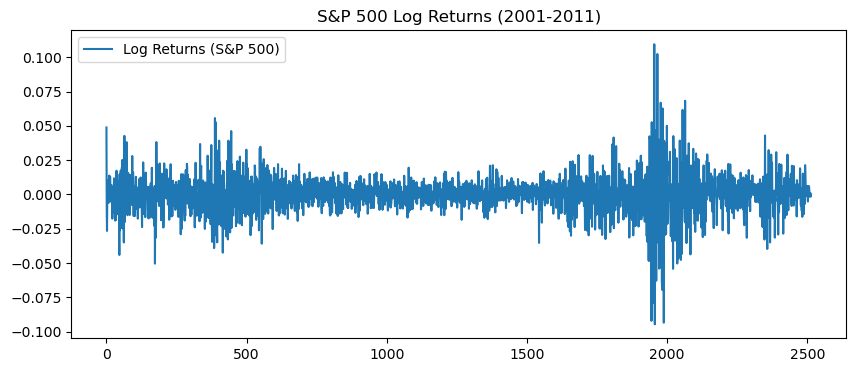

[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['DGS10']: Exception('%ticker%: No timezone found, symbol may be delisted')


/var/folders/pm/gyny_pw906z6y671sxfgb40h0000gn/T/ipykernel_1077/2568731955.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rf = rf.reindex(date).fillna(method="ffill") / 100  # Réalignement sur les dates du S&P 500


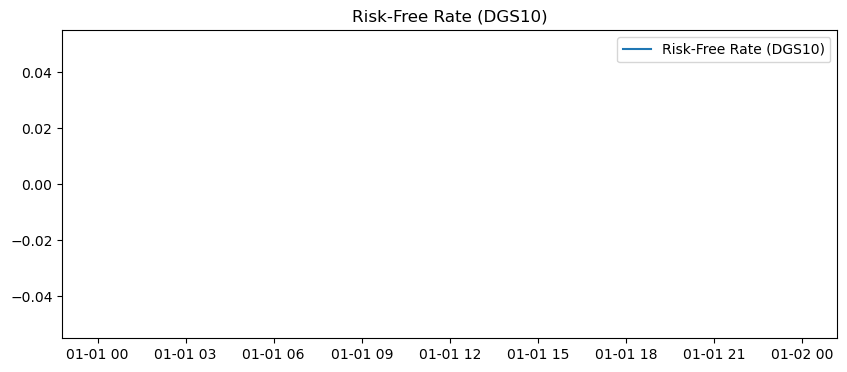

Running Backtests...

Backtest L1 Momentum Strategy LT:


IndexError: index -649 is out of bounds for axis 0 with size 1

In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

##############################
# Import des données

# Téléchargement des données du S&P 500
print("Downloading S&P 500 data...")
sp500 = yf.download('^GSPC', start='1965-01-01', end='2011-01-01')
sp500 = sp500['Adj Close']
date = sp500.index

# Affichage des rendements log en différence
plt.figure(figsize=(10, 4))
plt.plot(np.diff(np.log(sp500.loc['2001':])), label="Log Returns (S&P 500)")
plt.title("S&P 500 Log Returns (2001-2011)")
plt.legend()
plt.show()

# Téléchargement des taux sans risque DGS10 via FRED
print("Downloading Risk-Free Rate (DGS10)...")
rf = yf.download('DGS10', start='1965-01-01', end='2011-01-01', interval="1mo")['Adj Close']
rf = rf.reindex(date).fillna(method="ffill") / 100  # Réalignement sur les dates du S&P 500
plt.figure(figsize=(10, 4))
plt.plot(rf['2001':], label="Risk-Free Rate (DGS10)")
plt.title("Risk-Free Rate (DGS10)")
plt.legend()
plt.show()

# Capital initial
w0 = 10000

##############################
# Stratégies
def backtest(strategy, start_date, end_date, sp500, rf, w0):
    """
    Fonction de backtest pour exécuter une stratégie.
    """
    sp500 = sp500.loc[start_date:end_date]
    rf = rf.loc[start_date:end_date]
    portfolio_value = w0
    history = []

    curr_vars = None
    for t in range(len(sp500)):
        price = sp500.iloc[:t+1].values
        curr_vars = strategy(price, w0, curr_vars)
        alloc = curr_vars['asset_alloc'] if 'asset_alloc' in curr_vars else 0
        daily_return = alloc * np.log(sp500.iloc[t] / sp500.iloc[t-1]) if t > 0 else 0
        portfolio_value *= (1 + daily_return + rf.iloc[t]/252)
        history.append(portfolio_value)

    return pd.Series(history, index=sp500.index)

def simple_summary_strat(bt_result):
    """
    Analyse simple des performances du backtest.
    """
    returns = bt_result.pct_change().dropna()
    total_return = bt_result.iloc[-1] / bt_result.iloc[0] - 1
    annualized_return = (1 + total_return) ** (252 / len(bt_result)) - 1
    annualized_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_vol if annualized_vol != 0 else np.nan

    print(f"Total Return: {total_return:.2%}")
    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Annualized Volatility: {annualized_vol:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    return {"Total Return": total_return, "Annualized Return": annualized_return,
            "Annualized Volatility": annualized_vol, "Sharpe Ratio": sharpe_ratio}

##############################
# Backtest des stratégies
print("Running Backtests...")

# L1 Momentum Strategy LT
print("\nBacktest L1 Momentum Strategy LT:")
result_lt = backtest(l1_momentum_strat_LT, '2001-01-01', '2011-01-01', sp500, rf, w0)
simple_summary_strat(result_lt)
plt.plot(result_lt, label="L1 Momentum LT")
plt.legend()

# L1 Momentum Strategy GT
print("\nBacktest L1 Momentum Strategy GT:")
result_gt = backtest(l1_momentum_strat_GT, '2001-01-01', '2011-01-01', sp500, rf, w0)
simple_summary_strat(result_gt)
plt.plot(result_gt, label="L1 Momentum GT")
plt.legend()

# L1 Momentum Strategy LGT
print("\nBacktest L1 Momentum Strategy LGT:")
result_lgt = backtest(l1_momentum_strat_LGT, '2001-01-01', '2011-01-01', sp500, rf, w0)
simple_summary_strat(result_lgt)
plt.plot(result_lgt, label="L1 Momentum LGT")
plt.legend()

# Moving Average Strategy
print("\nBacktest Moving Average Strategy:")
result_ma = backtest(ma_strat, '2001-01-01', '2011-01-01', sp500, rf, w0)
simple_summary_strat(result_ma)
plt.plot(result_ma, label="Moving Average Strategy")
plt.legend()

# L2 Strategy
print("\nBacktest L2 Strategy:")
result_l2 = backtest(l2_strat, '2001-01-01', '2011-01-01', sp500, rf, w0)
simple_summary_strat(result_l2)
plt.plot(result_l2, label="L2 Strategy")
plt.legend()

plt.title("Backtest Results")
plt.show()

##############################
# Analyse des Performances
print("\nAll strategies completed. Check the charts for performance comparison.")


In [24]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.linalg import solve

##############################
# Auxillary function: getD
def getD(n, diff):
    """
    Génère la matrice de différence d'ordre 'diff'.
    """
    D0 = -np.eye(n) + np.eye(n, k=1)
    D = D0[:-1]
    for _ in range(diff - 1):
        D = D @ D0
        D = D[:-1]
    return D

##############################
# l1 Trend Filter (First Difference)
def l1tf_diff1(x, lambd, k=1):
    """
    Filtrage L1 avec différence d'ordre k, utilisant cvxpy.psd_wrap pour éviter les erreurs de convergence.
    """
    n_obs = len(x)
    D = getD(n_obs, k)
    P = cp.psd_wrap(D @ D.T)  # Garantie que P est PSD
    q = -D @ x

    v = cp.Variable(n_obs - k)
    constraints = [cp.abs(v) <= lambd]
    obj = cp.Minimize(0.5 * cp.quad_form(v, P) + q @ v)
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.OSQP)

    if prob.status not in ["optimal", "optimal_inaccurate"]:
        raise ValueError("Optimization did not converge")

    trend = x - D.T @ v.value
    return trend

##############################
# Cross-validation for L1-T Filter
def cv_fit_l1tf_run(tr_set, cv_set, T1, T2, n_lambda, diff):
    lambdas = np.logspace(-1, 2, n_lambda)
    errors = []

    for lambd in lambdas:
        error = 0
        for i, x in enumerate(cv_set.T):
            train_data = tr_set[:, i]
            trend = l1tf_diff1(train_data, lambd, k=diff)
            pred = trend[-1] + np.arange(1, T2 + 1) * (trend[-1] - trend[-2])
            min_len = min(len(pred), len(x))
            error += np.mean((pred[:min_len] - x[:min_len])**2)
        errors.append(error)

    return lambdas[np.argmin(errors)]

def cv_fit_l1tf(x_hist, T1, T2, n_roll, n_lambda, diff=2):
    len_x = len(x_hist)
    cv_indices = [np.arange(i, i + T2) for i in range(len_x - T1 - T2, len_x - T2, n_roll)]
    tr_set = np.array([x_hist[i[0] - T1:i[0]] for i in cv_indices])
    cv_set = np.array([x_hist[i] for i in cv_indices])

    best_lambda = cv_fit_l1tf_run(tr_set, cv_set, T1, T2, n_lambda, diff)
    return best_lambda

##############################
# L1 Momentum Strategy Generator
def l1_momentum_strat_gen(data, w0, T1, T2, n_roll=12, n_lambda=15, risk_constrt=1, curr_vars=None):
    """
    Générateur générique de stratégies L1 Momentum.
    """
    T2_max = max(T2) if isinstance(T2, (list, tuple)) else T2

    if curr_vars is None:
        curr_vars = {"count": T2_max + 1, "pred_trend": None, "asset_alloc": None, "max_count": T2_max}

    if curr_vars["count"] > curr_vars["max_count"]:
        curr_vars["count"] = 1
        lambda_l1 = cv_fit_l1tf(data, T1, T2_max, n_roll=n_roll, n_lambda=n_lambda, diff=2)
        trend = l1tf_diff1(data[-T1:], lambda_l1, k=2)
        curr_vars["pred_trend"] = trend
        curr_vars["max_count"] = len(trend)

    pred_mu = curr_vars["pred_trend"][-1] - curr_vars["pred_trend"][-2]
    vol = np.mean(np.diff(data[-curr_vars["max_count"]:])**2)
    asset_alloc = pred_mu / (risk_constrt * w0 * vol)
    curr_vars["asset_alloc"] = np.clip(asset_alloc, -1, 1)
    curr_vars["count"] += 1
    return curr_vars

##############################
# Exemple : Backtest d'une stratégie L1 Momentum LT
def l1_momentum_strat_LT(data, w0, curr_vars=None):
    """
    Stratégie L1 Momentum à court terme (LT).
    """
    T2 = 130
    T1 = 4 * T2
    risk = 0.001
    return l1_momentum_strat_gen(np.log(data), w0, T1, T2, risk_constrt=risk, curr_vars=curr_vars)

##############################
# Téléchargement des données S&P 500
print("Downloading S&P 500 data...")
sp500 = yf.download('^GSPC', start='2001-01-01', end='2011-01-01')
sp500_log = np.log(sp500['Adj Close'])
w0 = 10000

##############################
# Backtest
def backtest(strategy, sp500_log, w0):
    portfolio_value = w0
    history = []
    curr_vars = None

    for t in range(1, len(sp500_log)):
        price = sp500_log.iloc[:t].values
        curr_vars = strategy(price, w0, curr_vars)
        alloc = curr_vars["asset_alloc"]
        daily_return = alloc * (sp500_log.iloc[t] - sp500_log.iloc[t - 1])
        portfolio_value *= (1 + daily_return)
        history.append(portfolio_value)

    return pd.Series(history, index=sp500_log.index[1:])

##############################
# Exécution du backtest
print("\nRunning Backtest for L1 Momentum LT Strategy...")
result_lt = backtest(l1_momentum_strat_LT, sp500_log, w0)

# Affichage des résultats
plt.figure(figsize=(10, 5))
plt.plot(result_lt, label="L1 Momentum LT Strategy", color="blue")
plt.title("Backtest: L1 Momentum LT Strategy")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed


Running Backtest for L1 Momentum LT Strategy...


IndexError: index -649 is out of bounds for axis 0 with size 1